<a href="https://colab.research.google.com/github/c21446024/Waste-Management/blob/main/WasteManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PreProcessing


In [ ]:
! pip3 install timm

In [ ]:
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = "/content/drive/MyDrive/images/images"
split_dir = "/content/drive/MyDrive/images/images_split"

if os.path.exists(split_dir):
    print(f"The split directory '{split_dir}' already exists. Deleting it.")
    shutil.rmtree(split_dir)

for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dir, split)
    os.makedirs(split_path, exist_ok=True)

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Process each category (class)
for category_name in sorted(os.listdir(dataset_dir)):
    category_dir = os.path.join(dataset_dir, category_name)
    if not os.path.isdir(category_dir):
        print(f"Skipping {category_name}: Not a directory.")
        continue

    print(f"Processing category: {category_name}, Path: {category_dir}")

    # Collect all PNG images, including from subdirectories
    images = []
    for root, _, files in os.walk(category_dir):
        for file in files:
            if file.lower().endswith('.png'):
                images.append(os.path.join(root, file))

    if len(images) == 0:
        print(f"Skipping category '{category_name}': No valid images found.")
        continue

    print(f"Found {len(images)} images in category '{category_name}'.")

    # Extract just the filenames for splitting
    image_filenames = [os.path.basename(img) for img in images]

    # Split the dataset into train, val, and test sets
    train_images, test_images = train_test_split(image_filenames, test_size=(val_ratio + test_ratio), random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Copy images to respective folders
    for split, image_list in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_category_dir = os.path.join(split_dir, split, category_name)
        os.makedirs(split_category_dir, exist_ok=True)
        for image_name in image_list:
            # Find the full original path of the image
            original_image_path = next((img for img in images if os.path.basename(img) == image_name), None)
            if original_image_path:
                shutil.copy(original_image_path, os.path.join(split_category_dir, image_name))

print("Dataset successfully split into train, val, and test sets!")


Processing category: aerosol_cans, Path: /content/drive/MyDrive/images/images/aerosol_cans
Found 500 images in category 'aerosol_cans'.
Processing category: aluminum_food_cans, Path: /content/drive/MyDrive/images/images/aluminum_food_cans
Found 500 images in category 'aluminum_food_cans'.
Processing category: aluminum_soda_cans, Path: /content/drive/MyDrive/images/images/aluminum_soda_cans
Found 500 images in category 'aluminum_soda_cans'.
Processing category: cardboard_boxes, Path: /content/drive/MyDrive/images/images/cardboard_boxes
Found 500 images in category 'cardboard_boxes'.
Processing category: cardboard_packaging, Path: /content/drive/MyDrive/images/images/cardboard_packaging
Found 500 images in category 'cardboard_packaging'.
Processing category: clothing, Path: /content/drive/MyDrive/images/images/clothing
Found 500 images in category 'clothing'.
Processing category: coffee_grounds, Path: /content/drive/MyDrive/images/images/coffee_grounds
Found 500 images in category 'coffe

In [ ]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader

# Paths to splits
train_dir = "/content/drive/MyDrive/images/images_split/train"
val_dir = "/content/drive/MyDrive/images/images_split/val"
test_dir = "/content/drive/MyDrive/images/images_split/test"

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# WasteDataset class definition (assuming subfolders represent classes)
class WasteDataset:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        from PIL import Image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Datasets
train_dataset = WasteDataset(root_dir=train_dir, transform=train_transform)
val_dataset = WasteDataset(root_dir=val_dir, transform=val_test_transform)
test_dataset = WasteDataset(root_dir=test_dir, transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 6312
Validation set size: 2693
Test set size: 2687


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Resnet18

In [ ]:
import torch.nn as nn
from torchvision import models

model = models.resnet18(pretrained=True)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [ ]:
import torch.optim as optim

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=True, path='checkpoint.pth'):

        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):

        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves the model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased, saving model to {self.path}...")
        torch.save(model.state_dict(), self.path)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing (training and validation)
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/train', transform=transform['train'])
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/val', transform=transform['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Replace the fully connected layer for custom dataset
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training configuration
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
misclassified_examples_all_epochs = []

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    misclassified_examples = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels for F1 score calculation
            all_preds.extend(predicted.cpu())
            all_labels.extend(labels.cpu())

            # Collect misclassified examples
            for i in range(labels.size(0)):
                if predicted[i] != labels[i]:
                    misclassified_examples.append({
                        'image': images[i].cpu(),
                        'true_label': labels[i].item(),
                        'predicted_label': predicted[i].item()
                    })

    # Store misclassified examples for analysis
    misclassified_examples_all_epochs.extend(misclassified_examples)

    # Calculate metrics
    train_loss = running_loss / len(train_loader)
    validation_loss = val_loss / len(val_loader)
    validation_accuracy = 100 * correct / total
    f1 = f1_score(
        torch.tensor(all_labels).numpy(),
        torch.tensor(all_preds).numpy(),
        average='weighted'
    )


    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)
    val_f1_scores.append(f1)

    # Print
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {validation_loss:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.2f}%, "
          f"Validation F1 Score: {f1:.4f}, "
          f"Misclassified Examples: {len(misclassified_examples)}")

    # Check for early stopping
    early_stopping(validation_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Save the model
torch.save(model.state_dict(), 'resnet18_finetuned.pth')
print("Training complete. Model saved as 'resnet18_finetuned.pth'.")

# Function to visualize misclassified examples
def visualize_misclassified_examples(misclassified_examples, class_names, num_images=10):
    """
    Displays misclassified images with their true and predicted labels.
    """
    num_images = min(len(misclassified_examples), num_images)
    plt.figure(figsize=(15, 10))
    for i, example in enumerate(misclassified_examples[:num_images]):
        image = example['image'].permute(1, 2, 0).numpy()
        image = (image * 255).clip(0, 255).astype('uint8')
        true_label = class_names[example['true_label']]
        predicted_label = class_names[example['predicted_label']]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Class names
class_names = train_dataset.classes
visualize_misclassified_examples(misclassified_examples_all_epochs, class_names, num_images=10)


Epoch 1/50


KeyboardInterrupt: 

In [ ]:
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
print(f"Validation Accuracies: {val_accuracies}")

Train Losses: [1.3862533587397952, 0.5505891361772411, 0.3256142241033641, 0.20809327946467834, 0.16611162812044525, 0.1354404404721778, 0.11355386839031872, 0.09906020136832287, 0.0955660565840927, 0.09914354921196296, 0.09885489456167426, 0.0880435381667933]
Validation Losses: [0.5947410506360671, 0.39086229599574035, 0.31474759098799787, 0.2796469334293814, 0.27897247206967546, 0.27208125152460794, 0.24807998920544325, 0.2558518505025217, 0.27362150790388967, 0.2690195241888218, 0.2675219242406242, 0.2891762417652096]
Validation Accuracies: [82.383229128356, 87.16439867598382, 89.59176167708716, 89.99632217727105, 90.58477381390217, 90.3641044501655, 91.39389481426996, 91.72489885987495, 90.65833026848107, 91.17322545053328, 91.28356013240162, 91.50422949613828]


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_misclassification_bar_chart(misclassified_examples, class_names):
    """
    Plots a bar chart showing the number of misclassified examples for each true class.

    :param misclassified_examples: List of misclassified examples with 'true_label' and 'predicted_label'.
    :param class_names: List of class names corresponding to label indices.
    """
    # Count misclassifications for each true label
    true_label_counts = Counter([example['true_label'] for example in misclassified_examples])

    # Sort labels by their indices
    sorted_labels = sorted(true_label_counts.keys())
    counts = [true_label_counts[label] for label in sorted_labels]

    # Get corresponding class names
    class_names_sorted = [class_names[label] for label in sorted_labels]

    # Plot the bar chart
    plt.figure(figsize=(14, 7))
    plt.bar(class_names_sorted, counts, color='red', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('True Label')
    plt.ylabel('Misclassified Count')
    plt.title('Number of Misclassified Examples per Class')
    plt.tight_layout()
    plt.show()

# Call the function with misclassified examples and class names
plot_misclassification_bar_chart(misclassified_examples_all_epochs, class_names)

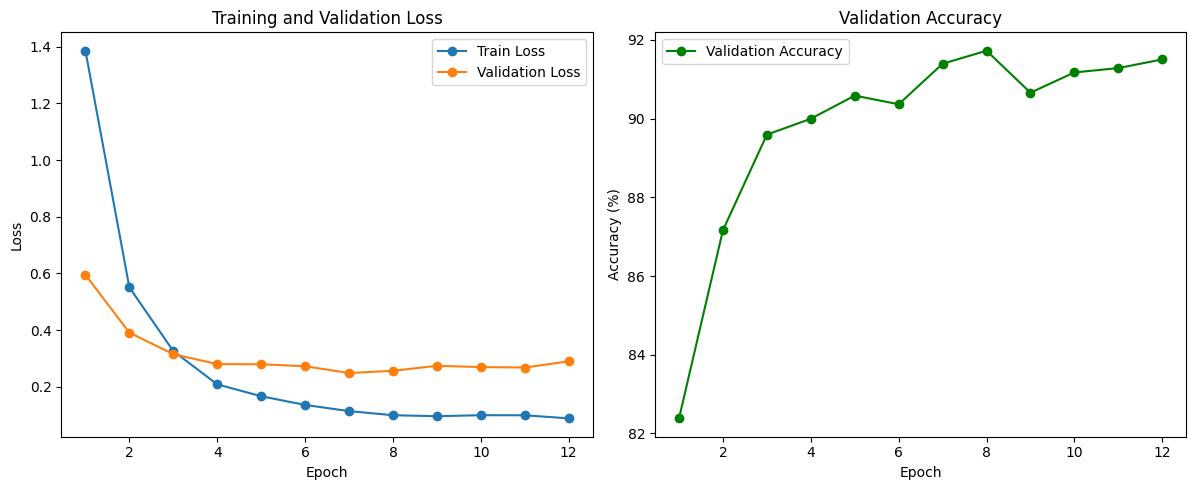

In [ ]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()


plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("ResNet18graph.png", dpi=300)



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='.2f')
plt.title('Normalized Confusion Matrix')
plt.savefig("ConfusionMatrix.png", dpi=300)
plt.show()


In [ ]:
import torch

# Load the checkpoint
checkpoint_path = '/content/drive/MyDrive/images/ResNet18.pth'
try:
    checkpoint = torch.load(checkpoint_path)
    print("Checkpoint successfully loaded.")
except Exception as e:
    print(f"Error loading checkpoint: {e}")
    checkpoint = None

if checkpoint is not None:
    if isinstance(checkpoint, dict):
        print("Checkpoint keys:", checkpoint.keys())

        # Check if it contains 'fc.weight'
        if 'fc.weight' in checkpoint:
            print(f"fc.weight shape: {checkpoint['fc.weight'].shape}")
        else:
            print("'fc.weight' not found in the checkpoint.")

        # Look for 'model_state_dict' if it's a full checkpoint
        if 'model_state_dict' in checkpoint:
            print("'model_state_dict' key found. This checkpoint is a full model checkpoint.")
        else:
            print("'model_state_dict' key not found. It might be a direct state_dict.")
    else:
        print("The checkpoint is not a dictionary. It might be a raw state_dict or an unsupported format.")


In [ ]:
import torch
from torchvision.models import resnet18

# Initialize ResNet-18
model = resnet18(pretrained=False)

num_classes = 30
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load the checkpoint
checkpoint_path = '/content/drive/MyDrive/images/ResNet18.pth'
checkpoint = torch.load(checkpoint_path)


try:
    model.load_state_dict(checkpoint)
    print("Model loaded successfully.")
except RuntimeError as e:
    print(f"Error loading model: {e}")


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/images/ResNet18.pth')
print("Checkpoint keys:", checkpoint.keys())


if isinstance(checkpoint, dict):
    print("State dictionary keys:", checkpoint.keys())
    if "fc.weight" in checkpoint:
        print(f"fc.weight shape: {checkpoint['fc.weight'].shape}")


# EffiecietNet b0

In [ ]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch import nn, optim

# Load pre-trained EfficientNet
model = models.efficientnet_b0(pretrained=True)

#  Modify the classifier to match the number of classes
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

import torch
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
train_losses, val_losses, val_accuracies = [], [], []


#Training loop with EfficientNet

early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True, path='best_efficientnet_model.pth')




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 170MB/s]


TypeError: EarlyStopping.__init__() got an unexpected keyword argument 'delta'

In [ ]:
pip install scikit-learn


In [ ]:
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    train_loss = running_loss / len(train_loader)
    validation_loss = val_loss / len(val_loader)
    validation_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {validation_loss:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.2f}%")


    scheduler.step(validation_loss)

# Save the model
torch.save(model.state_dict(), 'efficientnet_b0_model.pth')
print("Training complete. Model saved as 'efficientnet_b0_model.pth'.")

Starting epoch 1/50


KeyboardInterrupt: 

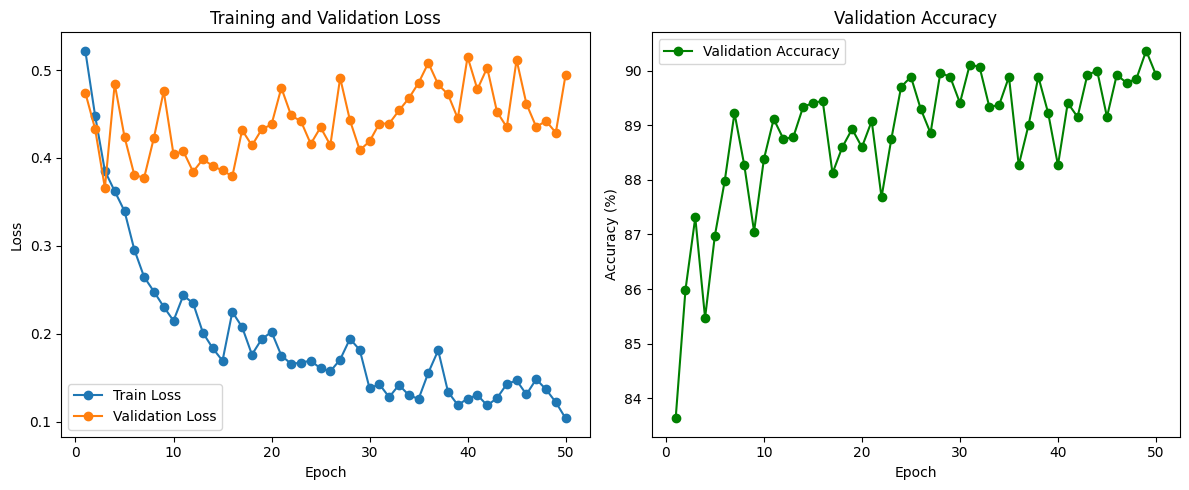

In [ ]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig("training_metricsEff0.png", dpi=300)  # Save as a high-quality PNG file


plt.show()


# EfficientNet-b7

In [ ]:
import torch
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
train_losses, val_losses, val_accuracies = [], [], []


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets (train and validation sets)
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [ ]:
from torchvision import models

model = models.efficientnet_b7(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 209MB/s]


In [ ]:
num_classes = len(train_dataset.classes)


in_features = model.classifier[1].in_features


model.classifier[1] = nn.Linear(in_features, num_classes)


model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Starting epoch 1/50
Epoch 1/50, Train Loss: 2.1588, Validation Loss: 0.7956, Validation Accuracy: 78.45%, Validation F1 Score: 0.7792
Number of misclassified examples: 586
Starting epoch 2/50
Epoch 2/50, Train Loss: 0.6781, Validation Loss: 0.3853, Validation Accuracy: 88.60%, Validation F1 Score: 0.8840
Number of misclassified examples: 896
Starting epoch 3/50
Epoch 3/50, Train Loss: 0.3261, Validation Loss: 0.2780, Validation Accuracy: 91.39%, Validation F1 Score: 0.9141
Number of misclassified examples: 1130
Starting epoch 4/50
Epoch 4/50, Train Loss: 0.1971, Validation Loss: 0.2595, Validation Accuracy: 91.95%, Validation F1 Score: 0.9189
Number of misclassified examples: 1349
Starting epoch 5/50
Epoch 5/50, Train Loss: 0.1444, Validation Loss: 0.2535, Validation Accuracy: 91.65%, Validation F1 Score: 0.9160
Number of misclassified examples: 1576
Starting epoch 6/50
Epoch 6/50, Train Loss: 0.1288, Validation Loss: 0.2475, Validation Accuracy: 92.13%, Validation F1 Score: 0.9209
Num

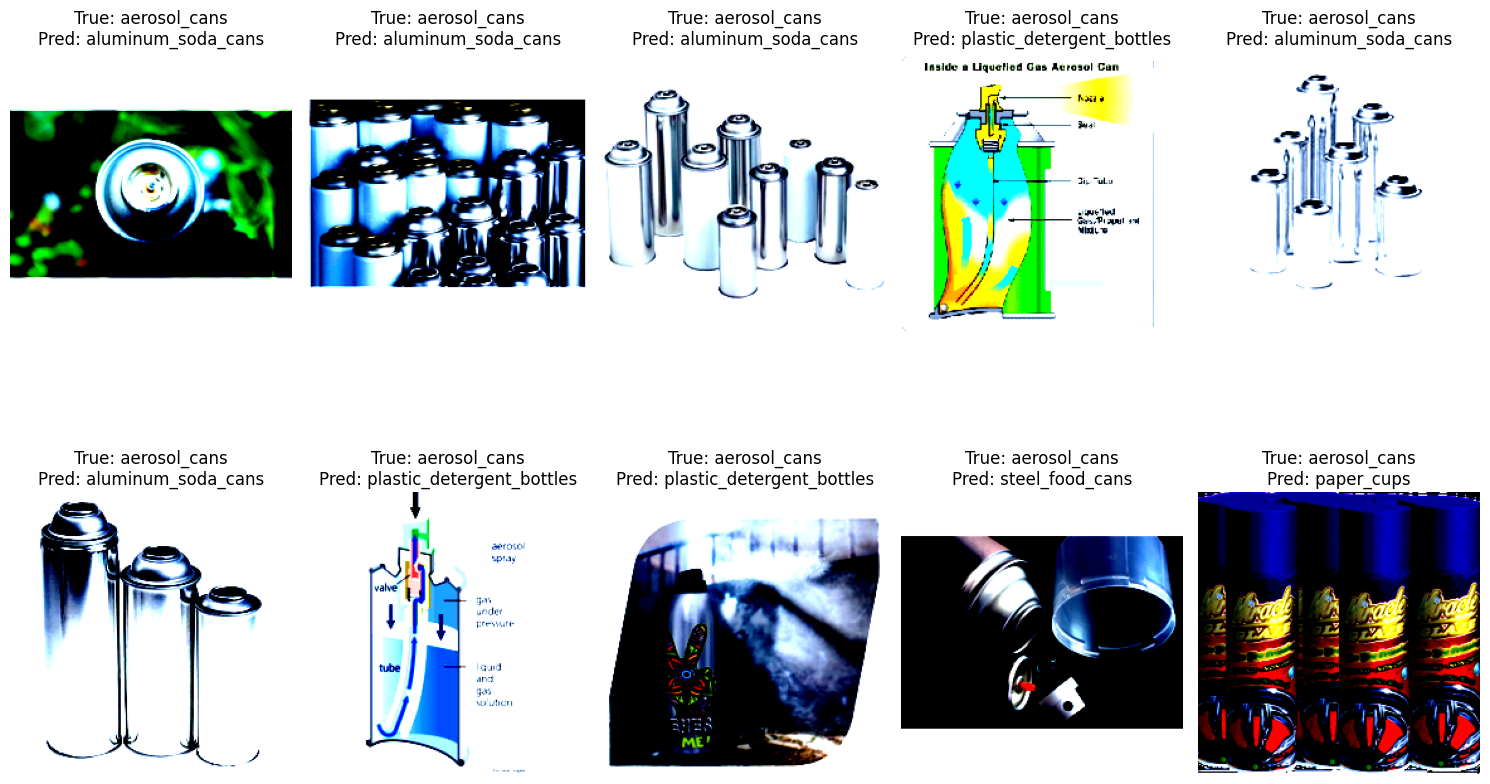

In [ ]:

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

misclassified_examples = []

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            all_preds.extend(predicted.cpu())
            all_labels.extend(labels.cpu())

            # Collect misclassified examples
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_examples.append({
                        'image': images[i].cpu(),
                        'true_label': labels[i].item(),
                        'predicted_label': predicted[i].item()
                    })

    # Calculate metrics
    train_loss = running_loss / len(train_loader)
    validation_loss = val_loss / len(val_loader)
    validation_accuracy = 100 * correct / total

    # Append metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    # Calculate F1 Score
    all_preds_tensor = torch.stack(all_preds)
    all_labels_tensor = torch.stack(all_labels)
    f1 = f1_score(all_labels_tensor.numpy(), all_preds_tensor.numpy(), average='weighted')
    val_f1_scores.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {validation_loss:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.2f}%, "
          f"Validation F1 Score: {f1:.4f}")
    print(f"Number of misclassified examples: {len(misclassified_examples)}")

# Save the model
torch.save(model.state_dict(), 'efficientnet_b7_finetuned.pth')
print("Training complete. Model saved as 'efficientnet_b7_finetuned.pth'.")

# Visualize misclassified examples
def visualize_misclassified_examples(misclassified_examples, class_names, num_images=10):
    """
    Displays misclassified images with their true and predicted labels.
    """
    num_images = min(len(misclassified_examples), num_images)
    plt.figure(figsize=(15, 10))
    for i, example in enumerate(misclassified_examples[:num_images]):
        image = example['image'].permute(1, 2, 0).numpy()
        image = (image * 255).clip(0, 255).astype('uint8')
        true_label = class_names[example['true_label']]
        predicted_label = class_names[example['predicted_label']]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()




# Visualize misclassified examples
class_names = train_dataset.classes
visualize_misclassified_examples(misclassified_examples, class_names, num_images=10)


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_misclassification_bar_chart(misclassified_examples, class_names):
    """
    Plots a bar chart showing the number of misclassified examples for each true class.

    :param misclassified_examples: List of misclassified examples with 'true_label' and 'predicted_label'.
    :param class_names: List of class names corresponding to label indices.
    """
    # Count misclassifications for each true label
    true_label_counts = Counter([example['true_label'] for example in misclassified_examples])

    # Sort labels by their indices
    sorted_labels = sorted(true_label_counts.keys())
    counts = [true_label_counts[label] for label in sorted_labels]

    # Get corresponding class names
    class_names_sorted = [class_names[label] for label in sorted_labels]

    # Plot the bar chart
    plt.figure(figsize=(14, 7))
    plt.bar(class_names_sorted, counts, color='red', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('True Label')
    plt.ylabel('Misclassified Count')
    plt.title('Number of Misclassified Examples per Class')
    plt.tight_layout()
    plt.show()

# Call the function with misclassified examples and class names
plot_misclassification_bar_chart(misclassified_examples_all_epochs, class_names)

NameError: name 'misclassified_examples_all_epochs' is not defined

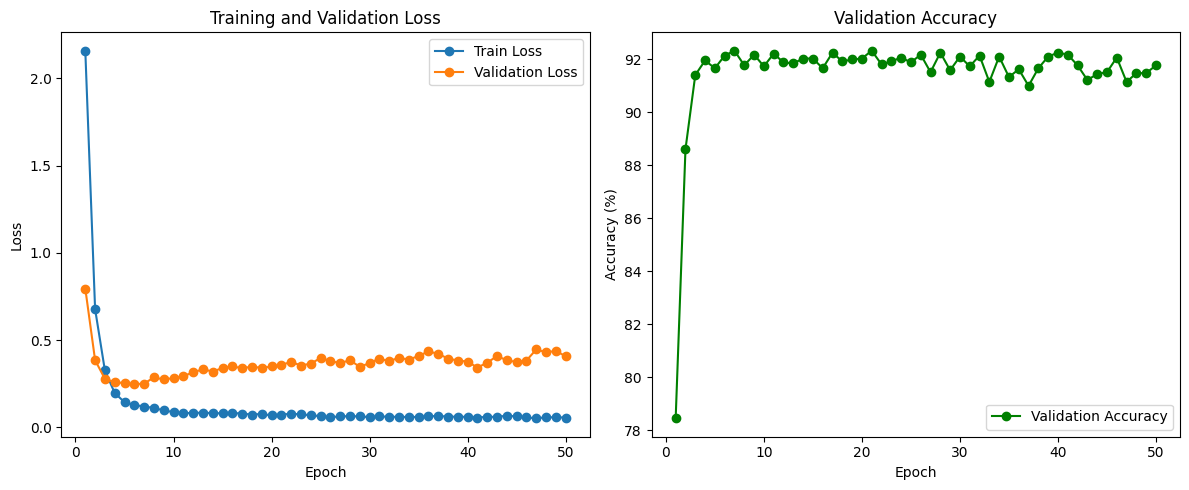

In [ ]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig("VG66.png", dpi=300)


plt.show()

# VG66

In [ ]:
import torch
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
train_losses, val_losses, val_accuracies = [], [], []


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the InceptionV3 model
model = models.inception_v3(pretrained=True)

for param in model.parameters():
    param.requires_grad = False


num_classes = len(train_dataset.classes)


model.fc = nn.Linear(model.fc.in_features, num_classes)


model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [ ]:


# Training loop
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

misclassified_examples = []
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        logits = outputs[0]


        if logits.shape[0] != labels.shape[0]:
            print(f"Warning: Mismatch in batch size: logits {logits.shape[0]} vs labels {labels.shape[0]}")

        if logits.shape[0] != labels.shape[0]:
            logits = logits[:labels.shape[0]]


        labels = labels.long()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)


            logits = outputs[0]

            if logits.shape[0] != labels.shape[0]:
                print(f"Warning: Mismatch in batch size: logits {logits.shape[0]} vs labels {labels.shape[0]}")


            labels = labels.long()


            if logits.shape[0] != labels.shape[0]:
                logits = logits[:labels.shape[0]]

            loss = criterion(logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(logits, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels for F1 score calculation
            all_preds.extend(predicted.cpu())
            all_labels.extend(labels.cpu())

            # Collect misclassified examples
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_examples.append({
                        'image': images[i].cpu(),
                        'true_label': labels[i].item(),
                        'predicted_label': predicted[i].item()
                    })

    # Calculate metrics
    train_loss = running_loss / len(train_loader)
    validation_loss = val_loss / len(val_loader)
    validation_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    # Calculate F1 Score
    all_preds_tensor = torch.stack(all_preds)
    all_labels_tensor = torch.stack(all_labels)
    f1 = f1_score(all_labels_tensor.numpy(), all_preds_tensor.numpy(), average='weighted')
    val_f1_scores.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {validation_loss:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.2f}%, "
          f"Validation F1 Score: {f1:.4f}")
    print(f"Number of misclassified examples: {len(misclassified_examples)}")

    scheduler.step(validation_loss)

# Save the model
torch.save(model.state_dict(), 'inception_v3_finetuned.pth')
print("Training complete. Model saved as 'inception_v3_finetuned.pth'.")

# Visualize misclassified examples
def visualize_misclassified_examples(misclassified_examples, class_names, num_images=10):
    """
    Displays misclassified images with their true and predicted labels.
    """
    num_images = min(len(misclassified_examples), num_images)
    plt.figure(figsize=(15, 10))
    for i, example in enumerate(misclassified_examples[:num_images]):
        image = example['image'].permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
        image = (image * 255).clip(0, 255).astype('uint8')  # Scale to 0-255
        true_label = class_names[example['true_label']]
        predicted_label = class_names[example['predicted_label']]

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()




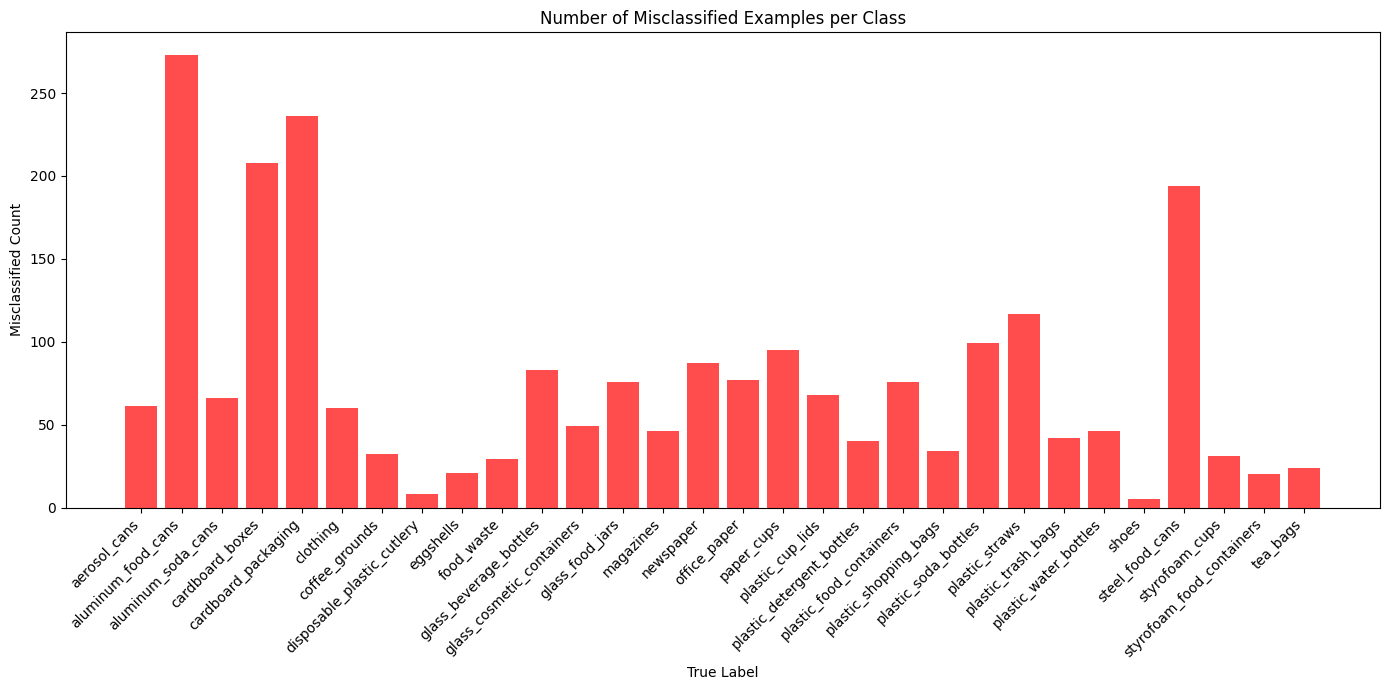

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_misclassification_bar_chart(misclassified_examples, class_names):
    """
    Plots a bar chart showing the number of misclassified examples for each true class.

    :param misclassified_examples: List of misclassified examples with 'true_label' and 'predicted_label'.
    :param class_names: List of class names corresponding to label indices.
    """

    true_label_counts = Counter([example['true_label'] for example in misclassified_examples])


    sorted_labels = sorted(true_label_counts.keys())
    counts = [true_label_counts[label] for label in sorted_labels]



    class_names_sorted = [class_names[label] for label in sorted_labels]

    # Plot the bar chart
    plt.figure(figsize=(14, 7))
    plt.bar(class_names_sorted, counts, color='red', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('True Label')
    plt.ylabel('Misclassified Count')
    plt.title('Number of Misclassified Examples per Class')
    plt.tight_layout()
    plt.show()

# Call the function with misclassified examples and class names
plot_misclassification_bar_chart(misclassified_examples_all_epochs, class_names)


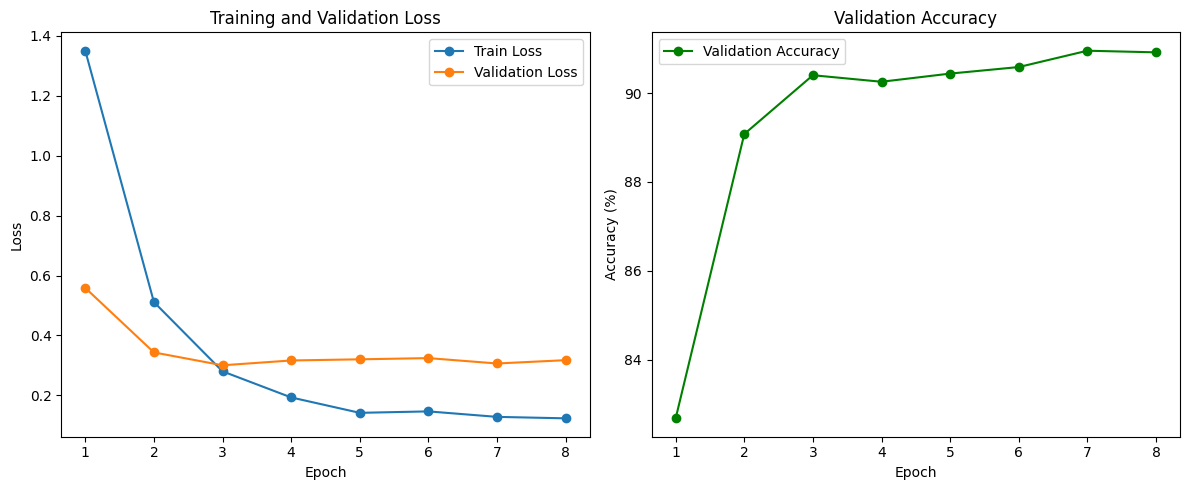

In [ ]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig("VG66.png", dpi=300)  # Save as a high-quality PNG file


plt.show()


# InceptionV3


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array




In [ ]:
from torchvision import models


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
Epoch 1/50, Train Loss: 2.3421, Validation Loss: 0.5198, Validation Accuracy: 84.08%, Validation F1 Score: 0.8390, Misclassified Examples: 433
Epoch 2/50
Epoch 2/50, Train Loss: 0.7460, Validation Loss: 0.3647, Validation Accuracy: 87.50%, Validation F1 Score: 0.8713, Misclassified Examples: 340
Epoch 3/50
Epoch 3/50, Train Loss: 0.4181, Validation Loss: 0.2797, Validation Accuracy: 90.92%, Validation F1 Score: 0.9090, Misclassified Examples: 247
Epoch 4/50
Epoch 4/50, Train Loss: 0.3020, Validation Loss: 0.2591, Validation Accuracy: 90.81%, Validation F1 Score: 0.9042, Misclassified Examples: 250
Epoch 5/50
Epoch 5/50, Train Loss: 0.2248, Validation Loss: 0.2668, Validation Accuracy: 91.69%, Validation F1 Score: 0.9167, Misclassified Examples: 226
Epoch 6/50
Epoch 6/50, Train Loss: 0.2031, Validation Loss: 0.2505, Validation Accuracy: 91.32%, Validation F1 Score: 0.9105, Misclassified Examples: 236
Epoch 7/50
Epoch 7/50, Train Loss: 0.1903, Validation Loss: 0.2427, Validati

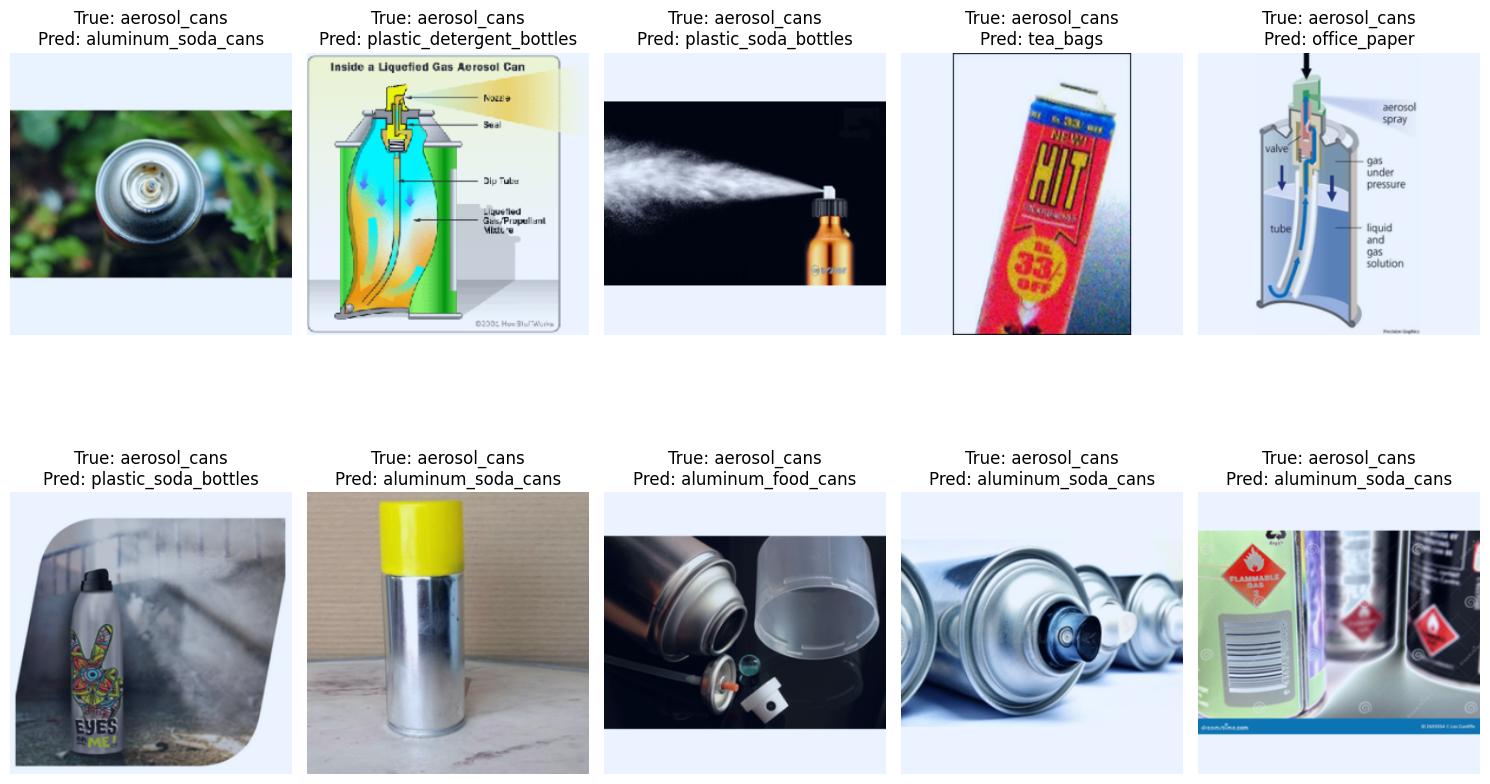

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from collections import Counter


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing (training and validation)
transform = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/train', transform=transform['train'])
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/val', transform=transform['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained InceptionV3 model
model = models.inception_v3(pretrained=True)


model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
misclassified_examples_all_epochs = []

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        if isinstance(outputs, tuple):
            main_output, aux_output = outputs
            loss = criterion(main_output, labels) + 0.4 * criterion(aux_output, labels)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    misclassified_examples = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels for F1 score calculation
            all_preds.extend(predicted.cpu())
            all_labels.extend(labels.cpu())

            # Collect misclassified examples
            for i in range(labels.size(0)):
                if predicted[i] != labels[i]:
                    misclassified_examples.append({
                        'image': images[i].cpu(),
                        'true_label': labels[i].item(),
                        'predicted_label': predicted[i].item()
                    })

    # Store misclassified examples for analysis
    misclassified_examples_all_epochs.extend(misclassified_examples)

    # Calculate metrics
    train_loss = running_loss / len(train_loader)
    validation_loss = val_loss / len(val_loader)
    validation_accuracy = 100 * correct / total
    f1 = f1_score(
        torch.tensor(all_labels).numpy(),
        torch.tensor(all_preds).numpy(),
        average='weighted'
    )

    # Append metrics for visualization
    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)
    val_f1_scores.append(f1)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {validation_loss:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.2f}%, "
          f"Validation F1 Score: {f1:.4f}, "
          f"Misclassified Examples: {len(misclassified_examples)}")

    # Check for early stopping
    early_stopping(validation_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Save the model
torch.save(model.state_dict(), 'inceptionv3_finetuned.pth')
print("Training complete. Model saved as 'inceptionv3_finetuned.pth'.")



# Class names
class_names = train_dataset.classes
visualize_misclassified_examples(misclassified_examples_all_epochs, class_names, num_images=10)


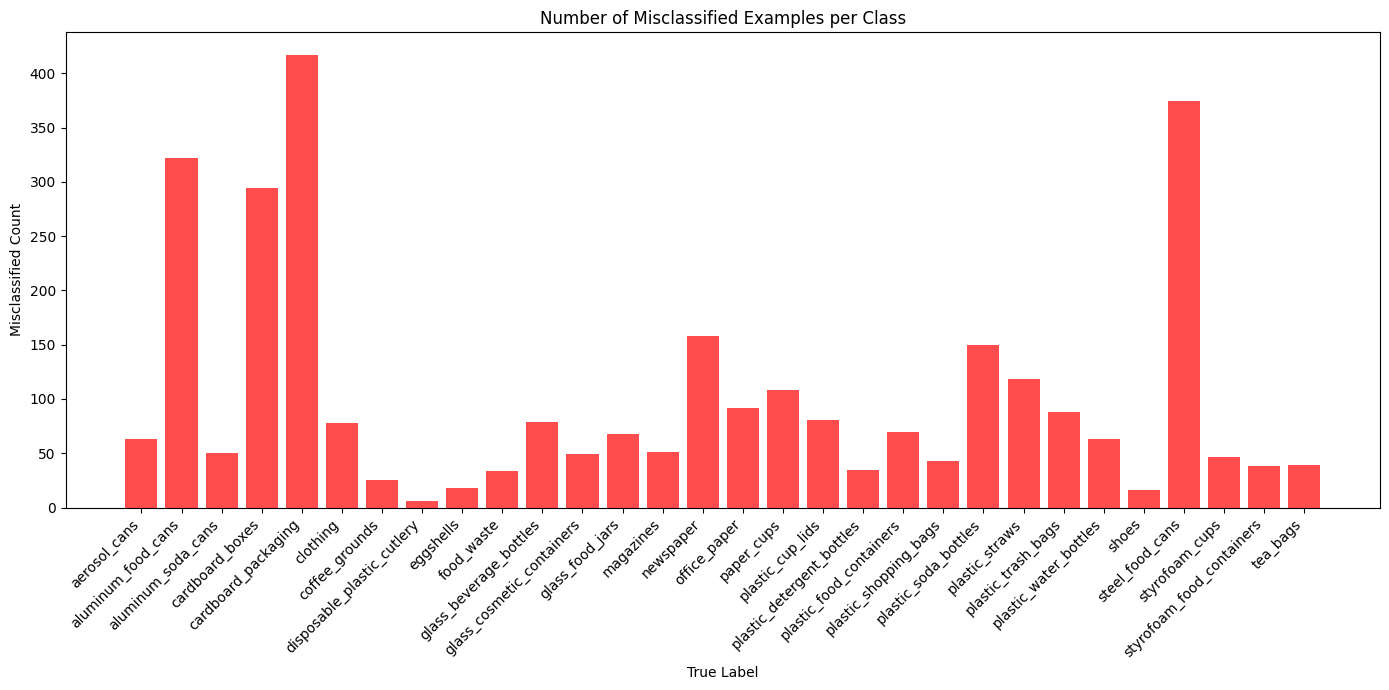

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_misclassification_bar_chart(misclassified_examples, class_names):
    """
    Plots a bar chart showing the number of misclassified examples for each true class.

    :param misclassified_examples: List of misclassified examples with 'true_label' and 'predicted_label'.
    :param class_names: List of class names corresponding to label indices.
    """
    # Count misclassifications for each true label
    true_label_counts = Counter([example['true_label'] for example in misclassified_examples])

    # Sort labels by their indices
    sorted_labels = sorted(true_label_counts.keys())
    counts = [true_label_counts[label] for label in sorted_labels]

    # Get corresponding class names
    class_names_sorted = [class_names[label] for label in sorted_labels]

    # Plot the bar chart
    plt.figure(figsize=(14, 7))
    plt.bar(class_names_sorted, counts, color='red', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('True Label')
    plt.ylabel('Misclassified Count')
    plt.title('Number of Misclassified Examples per Class')
    plt.tight_layout()
    plt.show()

# Call the function with misclassified examples and class names
plot_misclassification_bar_chart(misclassified_examples_all_epochs, class_names)

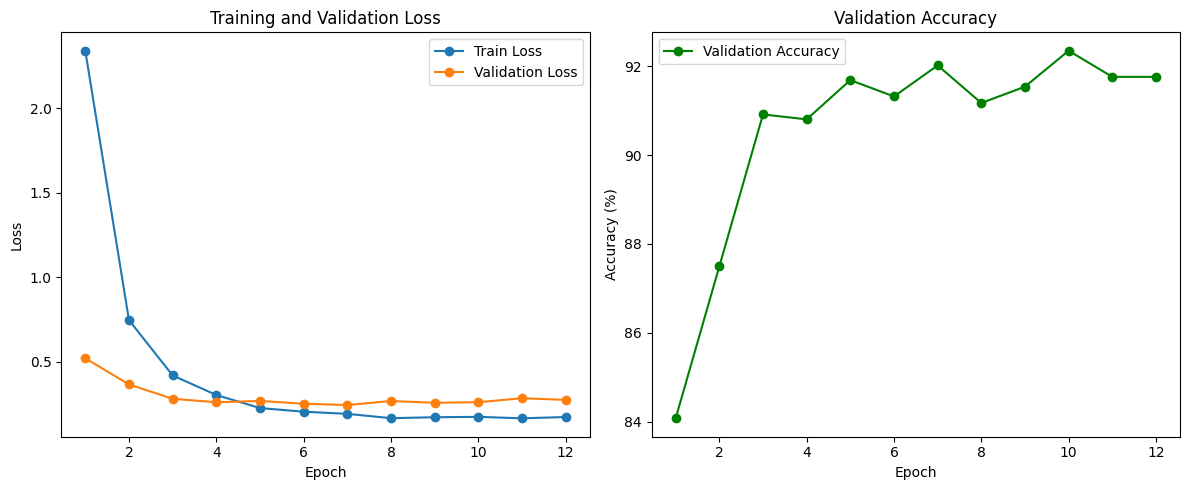

In [ ]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig("VG66.png", dpi=300)  # Save as a high-quality PNG file


plt.show()


# Vit


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
import torch.nn as nn
import torch.optim as optim

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/val', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load a different ViT model from timm
model = create_model('vit_small_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))
model.to(device)

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'vit_timm_quick.pth')
print("Quick ViT training complete and model saved.")


KeyboardInterrupt: 

In [ ]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torchvision import datasets
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the feature extractor and load pre-trained ViT with adjusted classifier
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Load the model and adjust for your number of classes (30) with mixed precision
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=30,
    ignore_mismatched_sizes=True
)
model.to(device)

# Mixed Precision Training (Updated for PyTorch 2.0+)
scaler = torch.amp.GradScaler()

# Freeze transformer layers and train only classifier initially
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Transform function for datasets
def transform_hf(image):
    return feature_extractor(images=image, return_tensors="pt")['pixel_values'].squeeze()

# Load datasets with optimized data loading
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/train', transform=transform_hf)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/images_split/val', transform=transform_hf)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

# Training loop with mixed precision (Updated and optimized)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass with the updated method
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

        # Backward pass with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Save the fine-tuned model
model.save_pretrained("vit_huggingface_finetuned")
print("Training complete and model saved.")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([30]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([30, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 